In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier as GBClassifier, \
    GradientBoostingRegressor as GBRegressor
from sklearn.metrics import confusion_matrix, classification_report, \
    PrecisionRecallDisplay, RocCurveDisplay, mean_squared_error, \
    r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from itertools import combinations

C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 12,
                     'xtick.labelsize' : 12,
                     'ytick.labelsize' : 12,
                     'axes.grid': False})

my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

In [6]:
def plot_decision_boundaries(X, classes, clf, 
                             class_names: dict = None, figsize = (6, 4)):
    '''
    classes: array-like containing numerical classes
    clf: the trained classifier
    class_names: dict mapping class numbers to class names    
    '''
    
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot()    
    x_min, y_min = X.min(axis = 0) - 1
    x_max, y_max = X.max(axis = 0) + 1
    '''
    artificial generated points evenly spaced within the region 
    delimitated by our data. x_grid and y_grid are matrices 
    containing x and y coordinates respectively.
    '''
    x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 1000), 
                                 np.linspace(y_min, y_max, 1000))   
    # put together x and y coordinates to build a matrix of (x,y) points
    xy_coordinates = np.vstack((x_grid.ravel(), y_grid.ravel())).T  
    # predictions of the artificial points
    pred = clf.predict(xy_coordinates) # 1d array with size=100_000  
    # Plot decision boundary and scatter plot
    contourf = ax.contourf(x_grid, y_grid, pred.reshape(1000, 1000), alpha = 0.6)    
    scatter = ax.scatter(X[:, 0], X[:, 1], c = classes, edgecolor = 'k')
    handles, labels = scatter.legend_elements()
    if class_names is not None:
        # each item in labels has the format '$\\mathdefault{number}$'
        keys = [int(''.join(filter(str.isdigit, string))) for string in labels] 
        labels = [class_names[i] for i in keys]
    ax.legend(handles, labels, loc = 'lower center', ncol = 2, 
              fontsize = 'small', bbox_to_anchor = (0, 1, 1, 1)) 
    ax.set_xlabel('1st Component', fontsize = 14)
    ax.set_ylabel('2nd Component', fontsize = 14)
    ax.set_xticks([])
    ax.set_yticks([])

In [7]:
# def plot_train_test_error(regressor, X_test, n_estimators=100):
#     n = regressor.n_estimators_
#     test_score = np.zeros(n)
#     for i, y_pred in enumerate(regressor.staged_predict(X_test)):
#         test_score[i] = regressor.loss_(y_test, y_pred)    
#     fig = plt.figure(figsize=(6, 4))
#     ax = plt.subplot()
#     ax.plot(np.arange(n) + 1,reg.train_score_,
#              label="Train Set Error")
#     ax.plot(np.arange(n) + 1, test_score, 
#              label="Test Set Error")
#     ax.set_xlabel("Boosting Iterations", fontsize=14)
#     ax.set_ylabel("Error", fontsize=14)
#     ax.legend()
#     return ax

In [8]:
def plot_score(report:'cv_results_', score_name='score', 
               legend_name=None, ax=None):
    if legend_name is None:
        legend_name = score_name
    if ax is None:
        fig = plt.figure(figsize=(6,4))
        ax = fig.add_subplot()
    
    # test score
    mean_val_score = report['mean_test_'+score_name]
    std_val_score = report['std_test_'+score_name]
    n = len(mean_val_score)
    x = range(n)
    ax.plot(x, mean_val_score, label='Validation set '+legend_name)
    ax.fill_between(x, mean_val_score - std_val_score, 
                     mean_val_score + std_val_score, alpha = 0.2)
    
    # train score
    if 'mean_train_'+score_name in report:
        mean_train_score = report['mean_train_'+score_name]
        std_train_score = report['std_train_'+score_name]
        ax.plot(x, mean_train_score, label='Train set '+legend_name)
        ax.fill_between(x, mean_train_score - std_train_score, 
                        mean_train_score + std_train_score, 
                        alpha=0.2)    
    return ax

In [9]:
def plot_confusion_mtx(cm: 'confusion matrix', labels = None, 
                       figsize = (3,3), binary = False, ax=None):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
    sns.heatmap(cm, annot = True, fmt = '0', annot_kws = {"fontsize": 16}, 
                cmap = "Blues", cbar = False, ax = ax)
    ax.set_xlabel('Predicted Class', fontsize = 14)
    ax.set_ylabel('Actual Class', fontsize = 14)
    if labels is None:
        labels = range(1, cm.shape[1] + 1)     
    ax.set_xticks(ax.get_xticks(), labels)
    ax.set_yticks(ax.get_yticks(), labels)
    if binary:
        ax.set_xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
        ax.set_yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
    return ax

In [10]:
def plot_multiclass_roc(clf, X, y, clf_name='', ax=None):
    if not isinstance(y, type(np.array([]))):
        y = y.values
    if ax is None:
        fig = plt.figure(figsize = (6, 4))
        ax = fig.add_subplot()
    y_pred_proba = clf.predict_proba(X)   
    for i, label in enumerate(np.unique(y)):
        class_i_arr = (y == label).astype(int)
        class_i_prob_arr = y_pred_proba[:, i]
        RocCurveDisplay.from_predictions(class_i_arr, class_i_prob_arr,
                        name = clf_name + f'class {label}', ax = ax)
    random = ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), 'k--', 
                 label = 'Random Classifier')
    ax.set_ylabel('True Positive Rate', fontsize = 14)
    ax.set_xlabel('False Positive Rate', fontsize = 14)
    return ax

# Data Preparation

In [11]:
X_train = pd.read_csv('best_X_train.csv', header = 0)
X_test = pd.read_csv('best_X_test.csv', header = 0)
X_train_full = pd.read_csv('old datasets/X_train_wo_outliers_num.csv', header = 0, index_col = 0)
X_test_full = pd.read_csv('old datasets/X_test_no_red.csv', header = 0)
y_train = pd.read_csv('y_train_wo_outliers_num.csv', header = None)[0]
y_test = pd.read_fwf('y_test.txt', header = None)[0]

In [12]:
X_train.columns = X_train.columns.astype(int)
X_test.columns = X_test.columns.astype(int)
X_train_full.columns = X_train_full.columns.astype(int)
X_test_full.columns = X_test_full.columns.astype(int)

In [13]:
X_train.shape, y_train.shape

((7274, 23), (7274,))

In [14]:
X_test.shape, y_test.shape

((2947, 23), (2947,))

In [15]:
with open("features.txt") as f:
    lines = f.read().splitlines() 

features = {}
for line in lines:
    idx, name = line.split()
    features[int(idx)-1] = name

In [16]:
with open('activity_labels.txt') as f:
    lines = f.read().splitlines()

activities = {}
for line in lines:
    label, activity = line.split()
    activities[int(label)] = activity

In [17]:
# let's remove the LAYING activity from the train set

filter_idx = y_train[y_train != 6].index
y_train = y_train[filter_idx]
X_train = X_train.loc[filter_idx, :]

In [18]:
X_train.shape, y_train.shape

((5896, 23), (5896,))

In [19]:
# let's remove the LAYING activity from the test set

filter_idx = y_test[y_test != 6].index
y_test = y_test[filter_idx]
X_test = X_test.loc[filter_idx, :]

In [20]:
X_test.shape, y_test.shape

((2410, 23), (2410,))

In [21]:
del activities[6]

In [22]:
activities

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING'}

# Univariate Regression

In [300]:
mid_corr_attr = []
for pair in combinations(X_train.columns,2):
    attr1, attr2 = pair
    corr_coef = np.corrcoef(X_train[attr1], X_train[attr2])[0,1]
    if .40 < corr_coef < .60 or -.40 < corr_coef < -.60:
        mid_corr_attr.append(pair)

In [301]:
len(mid_corr_attr)

11

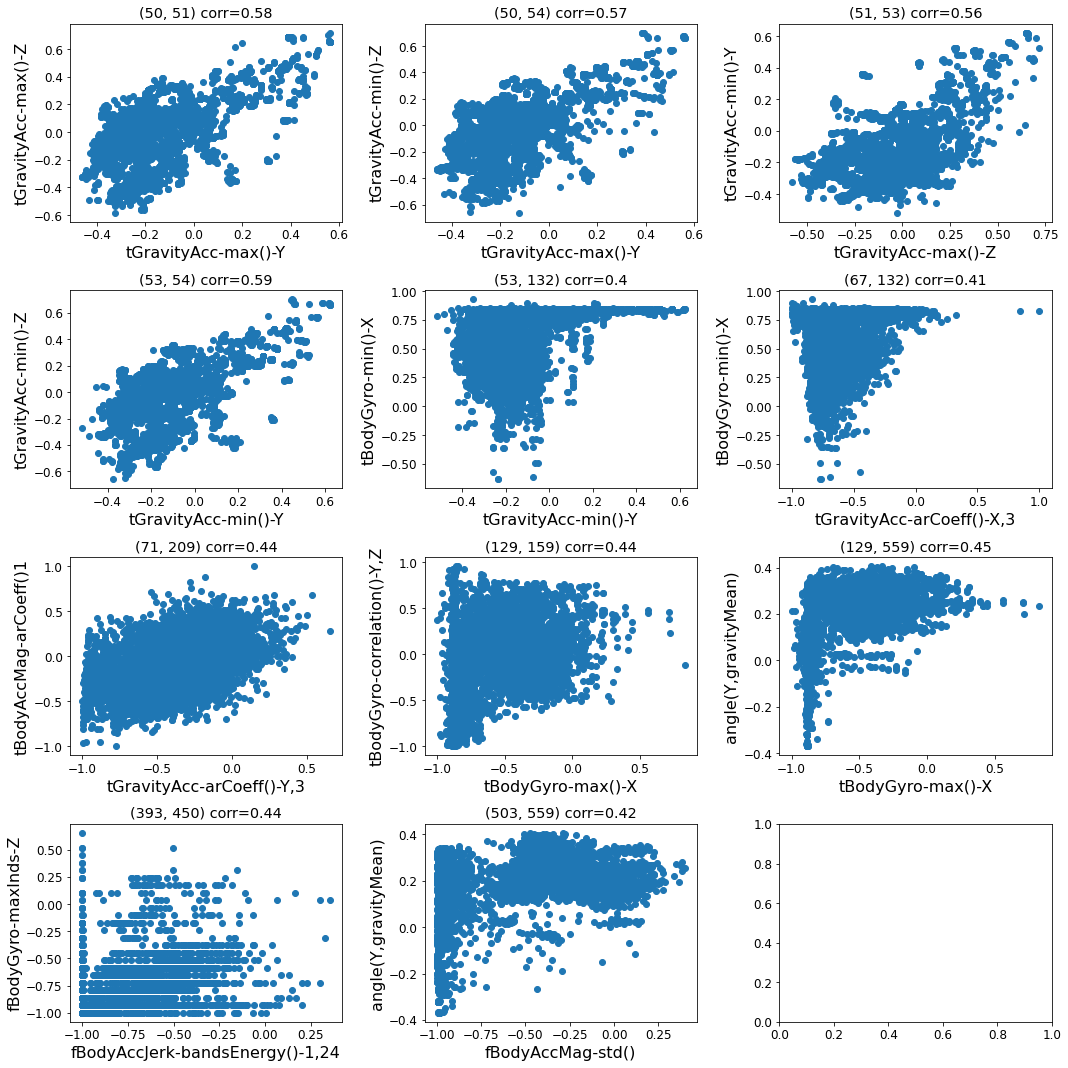

In [302]:
fig, ax = plt.subplots(4,3, figsize=(15,15))
ax = ax.ravel()
for i, pair in enumerate(mid_corr_attr):
    attr1, attr2 = pair
    coeff = np.corrcoef(X_train[attr1], X_train[attr2])[0,1]
    ax[i].scatter(X_train[attr1], X_train[attr2])
    ax[i].set_xlabel(attr1)
    ax[i].set_ylabel(attr2)
    ax[i].set_xlabel(features[attr1], fontsize = 16)
    ax[i].set_ylabel(features[attr2], fontsize = 16)
    ax[i].set_title(f'{pair} corr={coeff:.2}')
fig.tight_layout()
plt.show()

we can make a simple regression with pair (71,209), and (503,559) since they seem iteresting correlations



In [303]:
# (71, 209)
x, y = X_train[71].values.reshape(-1,1), X_train[209].values
reg = GBRegressor(random_state = 5)
reg.fit(x, y)

GradientBoostingRegressor(random_state=5)

In [304]:
x_test, target = X_test[71].values.reshape(-1,1), X_test[209].values
r2_train = reg.score(x,y)
r2_test = reg.score(x_test,target)

r2_train, r2_test

(0.2530161938782227, 0.17017191493341854)

In [305]:
y_pred = reg.predict(x_test)
mse_train = mean_squared_error(y, reg.predict(x))
mse_test = mean_squared_error(target, y_pred)

mse_train, mse_test

(0.05931500718850969, 0.05720684893932692)

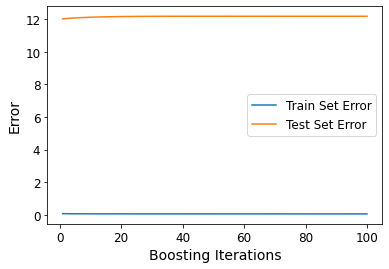

In [401]:
plot_train_test_error(reg, x_test)
plt.show()

In [320]:
params = {"n_estimators": list(range(50,501,50))}#,"learning_rate": [0.01]}

In [321]:
scores = ['r2','neg_mean_squared_error']
gridsearch = GridSearchCV(GBRegressor(random_state=5), params, 
                          cv = 5, n_jobs=-1, scoring=scores,
                          refit='r2',
                          return_train_score=True)

In [322]:
gridsearch.fit(x,y)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=5),
             n_jobs=-1,
             param_grid={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400,
                                          450, 500]},
             refit='r2', return_train_score=True,
             scoring=['r2', 'neg_mean_squared_error'])

In [323]:
results = gridsearch.cv_results_

In [324]:
results['mean_test_neg_mean_squared_error'] *= -1
results['mean_train_neg_mean_squared_error'] *= -1

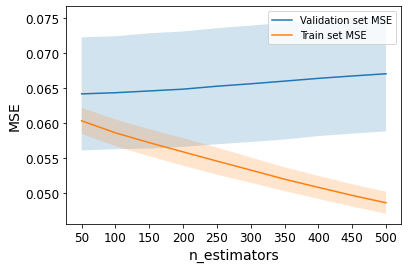

In [325]:
ax = plot_score(results, score_name='neg_mean_squared_error', 
           legend_name='MSE')
ax.set_xticks(range(10), list(range(50,501,50)))
ax.legend(fontsize='small')
ax.set_xlabel('n_estimators', fontsize=14)
ax.set_ylabel('MSE', fontsize=14)
plt.show()

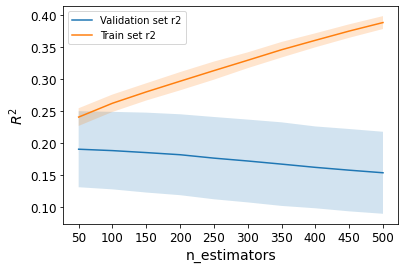

In [326]:
ax = plot_score(results, score_name='r2', 
           legend_name='r2')
ax.set_xticks(range(10), list(range(50,501,50)))
ax.legend(fontsize='small')
ax.set_xlabel('n_estimators', fontsize=14)
ax.set_ylabel('$R^2$', fontsize=14)
plt.show()

There is a trade-off between the number of estimators and the mean squared error. Particularly, it is evident that the model overfit on the train set as the number of estimator increase.

In [327]:
lr = np.linspace(0.1, 1,10)
params = {"learning_rate": lr}

In [328]:
scores = ['r2','neg_mean_squared_error']
gridsearch = GridSearchCV(GBRegressor(random_state=5), params, 
                          cv = 5, n_jobs=-1, scoring=scores,
                          refit='r2',
                          return_train_score=True)

In [329]:
gridsearch.fit(x,y)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             refit='r2', return_train_score=True,
             scoring=['r2', 'neg_mean_squared_error'])

In [330]:
results = gridsearch.cv_results_

In [331]:
results['mean_test_neg_mean_squared_error'] *= -1
results['mean_train_neg_mean_squared_error'] *= -1

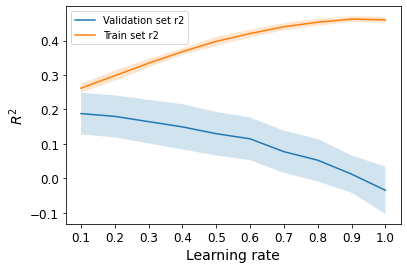

In [332]:
ax = plot_score(results, score_name='r2', 
           legend_name='r2')
ax.set_xticks(range(10), np.around(lr,1))
ax.legend(fontsize='small')
ax.set_xlabel('Learning rate',  fontsize=14)
ax.set_ylabel('$R^2$',  fontsize=14)
plt.show()

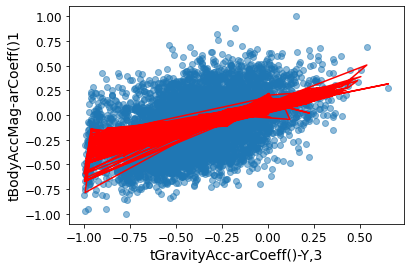

In [407]:
plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.5)
plt.plot(x, reg.predict(x), color='r')
plt.xlabel(features[71], fontsize=14)
plt.ylabel(features[209], fontsize=14)
plt.show()

In [374]:
params = dict(learning_rate = np.linspace(0.1, 1,10),
              n_estimators = list(range(50,501,50)),
              subsample = [.7,.8,.9,1],
              max_depth = list(range(3,6)))

In [375]:
gridsearch = GridSearchCV(GBRegressor(random_state=5, 
                                      validation_fraction = 0.1,
                                      n_iter_no_change = 10), 
                          params, cv = 3, n_jobs=-1, refit='r2', 
                          scoring=scores, return_train_score=True)

In [376]:
gridsearch.fit(x,y)

GridSearchCV(cv=3,
             estimator=GradientBoostingRegressor(n_iter_no_change=10,
                                                 random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400,
                                          450, 500],
                         'subsample': [0.7, 0.8, 0.9, 1]},
             refit='r2', return_train_score=True,
             scoring=['r2', 'neg_mean_squared_error'])

In [377]:
gridsearch.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}

In [381]:
results = gridsearch.cv_results_

In [393]:
results['mean_test_neg_mean_squared_error'] *= -1
results['mean_train_neg_mean_squared_error'] *= -1

In [383]:
# results

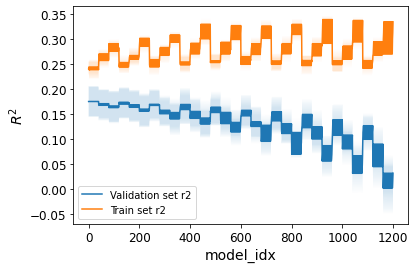

In [389]:
ax = plot_score(results, score_name='r2', 
           legend_name='r2')
# ax.set_xticks(range(10), list(range(50,501,50)))
ax.legend(fontsize='small')
ax.set_xlabel('model_idx', fontsize=14)
ax.set_ylabel('$R^2$', fontsize=14)
plt.show()

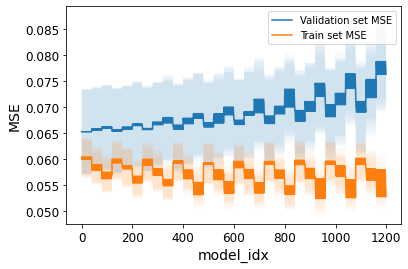

In [396]:
ax = plot_score(results, score_name='neg_mean_squared_error', 
           legend_name='MSE')
# ax.set_xticks(range(10), list(range(50,501,50)))
ax.legend(fontsize='small')
ax.set_xlabel('model_idx', fontsize=14)
ax.set_ylabel('MSE', fontsize=14)
plt.show()

In [494]:
# plot_train_test_error(gridsearch.best_estimator_, x_test)
# plt.show()

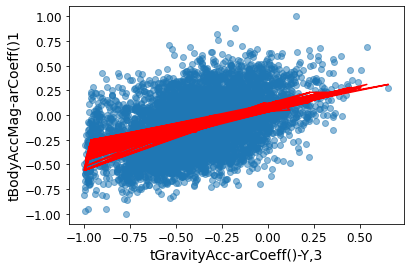

In [495]:
plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.5)
plt.plot(x, gridsearch.predict(x), color='r')
plt.xlabel(features[71], fontsize=14)
plt.ylabel(features[209], fontsize=14)
plt.show()

In [486]:
gridsearch.best_estimator_.n_estimators_

31

In [402]:
y_pred = gridsearch.predict(x_test)
mse_train = mean_squared_error(y, gridsearch.predict(x))
mse_test = mean_squared_error(target, y_pred)

mse_train, mse_test

(0.061530669816506775, 0.05677580596976203)

In [405]:
r2_train = gridsearch.score(x,y)
r2_test = gridsearch.score(x_test,target)

r2_train, r2_test

(0.22511323674491124, 0.1764245152539642)

## Multivariate regression

We use the same target variable used for the univariate analysis, however now we consider all the other 22 attributes as regressors. 

In [430]:
def adj_r2(regressor, X, y):
    r2_adj = 1 - (1 - regressor.score(X, y))*(len(y) - 1) / (len(y) - X.shape[1] - 1)
    return r2_adj

In [419]:
X_tr = X_train.drop(labels=209, axis=1).values
X_te = X_test.drop(labels=209, axis=1).values

In [420]:
X_tr.shape, y.shape

((5896, 22), (5896,))

In [421]:
X_te.shape, target.shape

((2410, 22), (2410,))

In [422]:
reg = GBRegressor(random_state=5).fit(X_tr, y)

In [423]:
y_pred = reg.predict(X_te)
mse_train = mean_squared_error(y, reg.predict(X_tr))
mse_test = mean_squared_error(target, y_pred)

mse_train, mse_test

(0.01683017860014994, 0.025015285286170072)

In [424]:
r2_train = reg.score(X_tr,y)
r2_test = reg.score(X_te,target)

r2_train, r2_test

(0.7880490711483101, 0.6371345971453015)

In [431]:
r2_train_adj = adj_r2(reg, X_tr,y)
r2_test_adj = adj_r2(reg, X_te,target)

r2_train_adj, r2_test_adj

(0.7872551122798039, 0.6337902155521706)

In [459]:
features_import = pd.DataFrame(list(zip([features[n] for n in X_train.columns if n != 209], reg.feature_importances_)))
features_import.set_index(0, drop = True, inplace=True)
features_import.index.name = 'Attributes'
features_import.columns = ['Importances']

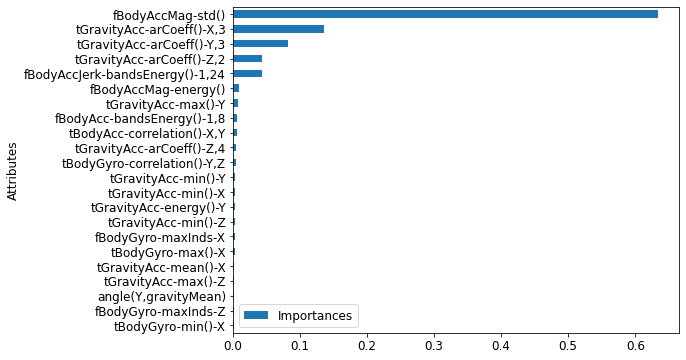

In [479]:
features_import.sort_values(by='Importances', ascending = True, inplace=True)
ax = features_import.plot.barh(figsize=(8,6), label=None)
ax.legend()
plt.show()

In [496]:
# grid search

gridsearch = GridSearchCV(GBRegressor(random_state=5, 
                                      validation_fraction = 0.1,
                                      n_iter_no_change = 10), 
                          params, cv = 3, n_jobs=-1, refit='r2', 
                          scoring=scores, return_train_score=True)

In [497]:
gridsearch.fit(X_tr,y)

GridSearchCV(cv=3,
             estimator=GradientBoostingRegressor(n_iter_no_change=10,
                                                 random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400,
                                          450, 500],
                         'subsample': [0.7, 0.8, 0.9, 1]},
             refit='r2', return_train_score=True,
             scoring=['r2', 'neg_mean_squared_error'])

In [498]:
gridsearch.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.9}

In [499]:
results = gridsearch.cv_results_

In [500]:
results['mean_test_neg_mean_squared_error'] *= -1
results['mean_train_neg_mean_squared_error'] *= -1

In [501]:
# results

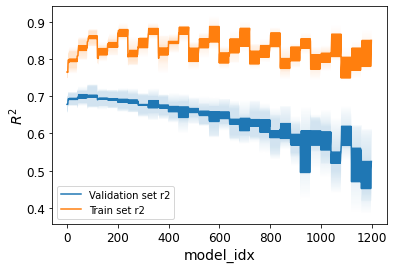

In [507]:
ax = plot_score(results, score_name='r2', 
           legend_name='r2')
# ax.set_xticks(range(10), list(range(50,501,50)))
ax.legend(fontsize='small')
ax.set_xlabel('model_idx', fontsize=14)
ax.set_ylabel('$R^2$', fontsize=14, labelpad=0)
plt.show()

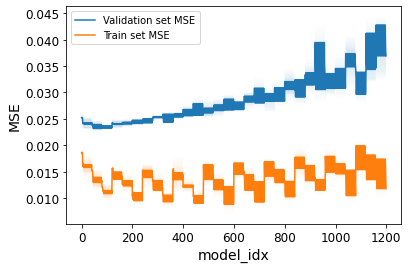

In [508]:
ax = plot_score(results, score_name='neg_mean_squared_error', 
           legend_name='MSE')
# ax.set_xticks(range(10), list(range(50,501,50)))
ax.legend(fontsize='small')
ax.set_xlabel('model_idx', fontsize=14)
ax.set_ylabel('MSE', fontsize=14)
plt.show()

In [494]:
# plot_train_test_error(gridsearch.best_estimator_, x_test)
# plt.show()

In [513]:
gridsearch.best_estimator_.n_estimators_

100

In [514]:
y_pred = gridsearch.predict(X_te)
mse_train = mean_squared_error(y, gridsearch.predict(X_tr))
mse_test = mean_squared_error(target, y_pred)

mse_train, mse_test

(0.013753750782207622, 0.025067287697563567)

In [515]:
r2_train = gridsearch.score(X_tr,y)
r2_test = gridsearch.score(X_te,target)

r2_train, r2_test

(0.8267920785191436, 0.6363802633152513)

In [516]:
r2_train_adj = adj_r2(gridsearch, X_tr,y)
r2_test_adj = adj_r2(gridsearch, X_te,target)

r2_train_adj, r2_test_adj

(0.8261432492542741, 0.63302892933659)

# Classification

In [539]:
clf = GBClassifier(random_state=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [540]:
print(classification_report(y_test, y_pred, 
                            target_names=activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.89      0.98      0.93       496
  WALKING_UPSTAIRS       0.88      0.88      0.88       471
WALKING_DOWNSTAIRS       0.97      0.85      0.91       420
           SITTING       0.87      0.78      0.82       491
          STANDING       0.82      0.90      0.86       532

          accuracy                           0.88      2410
         macro avg       0.89      0.88      0.88      2410
      weighted avg       0.88      0.88      0.88      2410



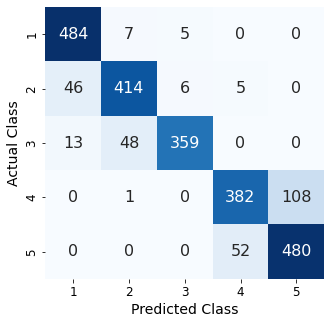

In [541]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_mtx(cm, figsize=(5, 5))
plt.show()

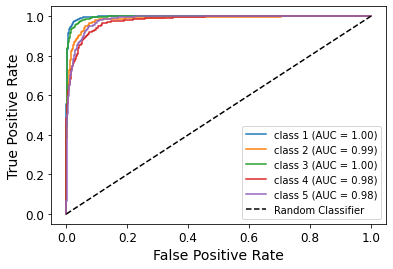

In [542]:
ax = plot_multiclass_roc(clf, X_test, y_test)
ax.legend(fontsize='10')
plt.show()

In [559]:
params = dict(learning_rate = [.1, .2, .3, .4, .5, .6],
              n_estimators = list(range(50,501,50)),
              subsample = [.8, .9, 1.],
              max_depth = list(range(3,6)))

In [560]:
scores = ['accuracy','neg_log_loss']
gridsearch = GridSearchCV(GBClassifier(random_state=5,
                                      validation_fraction = 0.2,
                                      n_iter_no_change = 10), 
                          params, cv = 3, n_jobs=-1, 
                          scoring=scores, refit='accuracy',
                          return_train_score=True)

In [561]:
gridsearch.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(n_iter_no_change=10,
                                                  random_state=5,
                                                  validation_fraction=0.2),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400,
                                          450, 500],
                         'subsample': [0.8, 0.9, 1.0]},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'neg_log_loss'])

In [571]:
gridsearch.best_params_

{'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 50, 'subsample': 1.0}

In [572]:
results = gridsearch.cv_results_

In [573]:
results['mean_test_neg_log_loss'] *= -1
results['mean_train_neg_log_loss'] *= -1

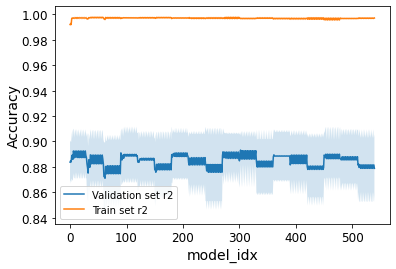

In [574]:
ax = plot_score(results, score_name='accuracy', 
           legend_name='r2')
# ax.set_xticks(range(10), list(range(50,501,50)))
ax.legend(fontsize='small')
ax.set_xlabel('model_idx', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14, labelpad=0)
plt.show()

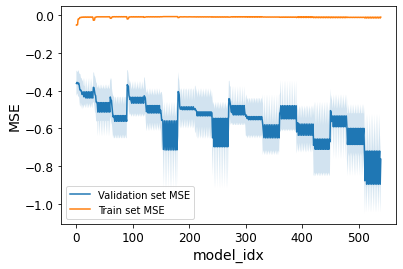

In [575]:
ax = plot_score(results, score_name='neg_log_loss', 
           legend_name='MSE')
# ax.set_xticks(range(10), list(range(50,501,50)))
ax.legend(fontsize='small')
ax.set_xlabel('model_idx', fontsize=14)
ax.set_ylabel('MSE', fontsize=14)
plt.show()

In [567]:
y_pred = gridsearch.predict(X_test)

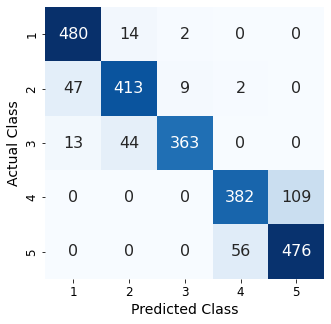

In [568]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_mtx(cm, figsize=(5, 5))
plt.show()

In [576]:
print(classification_report(y_test, y_pred, 
                            target_names=activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.89      0.97      0.93       496
  WALKING_UPSTAIRS       0.88      0.88      0.88       471
WALKING_DOWNSTAIRS       0.97      0.86      0.91       420
           SITTING       0.87      0.78      0.82       491
          STANDING       0.81      0.89      0.85       532

          accuracy                           0.88      2410
         macro avg       0.88      0.88      0.88      2410
      weighted avg       0.88      0.88      0.88      2410



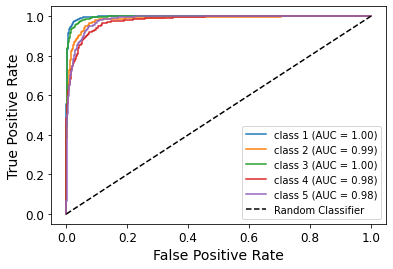

In [577]:
ax = plot_multiclass_roc(clf, X_test, y_test)
ax.legend(fontsize='10')
plt.show()

### XGBoost

In [ ]:
# labels should startf from 0 and shuld be numpy. Moreover, 
# pass use_label_encoder=False in the function to eliminate
# the warning

In [582]:
y_train_scaled = y_train.values -1
y_test_scaled = y_test.values -1

In [584]:
clf = XGBClassifier(random_state=5, n_jobs=-1, use_label_encoder=False)
clf.fit(X_train.values, y_train_scaled)
y_pred = clf.predict(X_test.values)

[17:35:01] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [591]:
print(classification_report(y_test_scaled, y_pred,
     target_names=activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.92      0.99      0.95       496
  WALKING_UPSTAIRS       0.89      0.90      0.89       471
WALKING_DOWNSTAIRS       0.97      0.87      0.92       420
           SITTING       0.88      0.77      0.82       491
          STANDING       0.82      0.91      0.86       532

          accuracy                           0.89      2410
         macro avg       0.90      0.89      0.89      2410
      weighted avg       0.89      0.89      0.89      2410



In [592]:
clf = XGBClassifier(random_state=5, use_label_encoder=False)

In [593]:
params = dict(n_estimators=[50, 100, 200],
              max_depth=[2,4,6],
              learning_rate = [.2,.3,.4,.5],
              gamma=[0,1],
              subsample=[0.5,1],
              reg_lambda=[1,2])

In [594]:
scores = ['accuracy','neg_log_loss']
gridsearch = GridSearchCV(clf , params, cv = 3, n_jobs=-1, 
                          scoring=scores, refit='accuracy',
                          return_train_score=True)

In [595]:
gridsearch.fit(X_train.values, y_train_scaled)

[18:04:02] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=False,
                                     validate_parameters=None, verbosity=N

In [596]:
gridsearch.best_params_

{'gamma': 0,
 'learning_rate': 0.3,
 'max_depth': 2,
 'n_estimators': 100,
 'reg_lambda': 2,
 'subsample': 0.5}

In [597]:
results = gridsearch.cv_results_

In [598]:
results['mean_test_neg_log_loss'] *= -1
results['mean_train_neg_log_loss'] *= -1

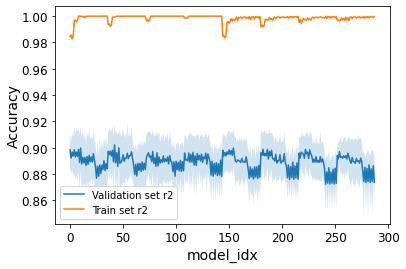

In [599]:
ax = plot_score(results, score_name='accuracy', 
           legend_name='r2')
# ax.set_xticks(range(10), list(range(50,501,50)))
ax.legend(fontsize='small')
ax.set_xlabel('model_idx', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14, labelpad=0)
plt.show()

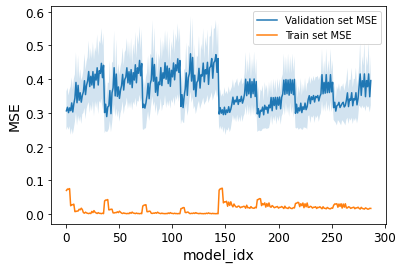

In [600]:
ax = plot_score(results, score_name='neg_log_loss', 
           legend_name='MSE')
# ax.set_xticks(range(10), list(range(50,501,50)))
ax.legend(fontsize='small')
ax.set_xlabel('model_idx', fontsize=14)
ax.set_ylabel('MSE', fontsize=14)
plt.show()

In [601]:
y_pred = gridsearch.predict(X_test.values)

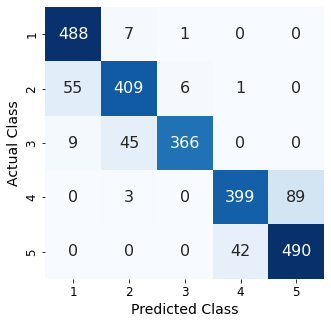

In [602]:
cm = confusion_matrix(y_test_scaled, y_pred)
plot_confusion_mtx(cm, figsize=(5, 5))
plt.show()

In [603]:
print(classification_report(y_test_scaled, y_pred, 
                            target_names=activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.88      0.98      0.93       496
  WALKING_UPSTAIRS       0.88      0.87      0.87       471
WALKING_DOWNSTAIRS       0.98      0.87      0.92       420
           SITTING       0.90      0.81      0.86       491
          STANDING       0.85      0.92      0.88       532

          accuracy                           0.89      2410
         macro avg       0.90      0.89      0.89      2410
      weighted avg       0.90      0.89      0.89      2410



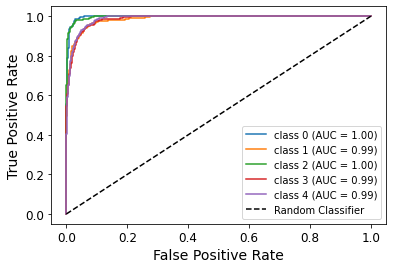

In [606]:
ax = plot_multiclass_roc(gridsearch, X_test.values, y_test_scaled)
ax.legend(fontsize='10')
plt.show()

# LightGBM

In [1]:
from lightgbm import LGBMClassifier

In [32]:
clf = LGBMClassifier(boosting_type='gbdt',  #'goss', #'dart'
                     max_depth=-1, # no limit
                     num_leaves=31,
                     n_estimators=100,
                     subsample_for_bin=200000,
#                      objective='binary',
                     reg_alpha=0.0, #L1 regularization term on weights
                     reg_lambda=0.0, #L2 regularization term on weights
                     random_state=42
                   )
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [23]:
clf = LGBMClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.91      0.98      0.94       496
           2       0.88      0.88      0.88       471
           3       0.96      0.86      0.91       420
           4       0.88      0.77      0.82       491
           5       0.81      0.91      0.85       532

    accuracy                           0.88      2410
   macro avg       0.89      0.88      0.88      2410
weighted avg       0.88      0.88      0.88      2410



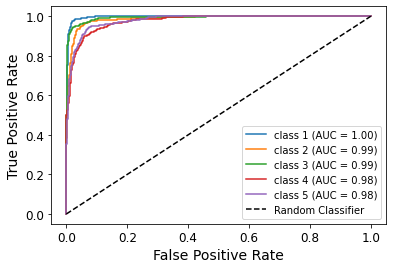

In [26]:
ax = plot_multiclass_roc(clf, X_test, y_test)
ax.legend(fontsize='10')
plt.show()

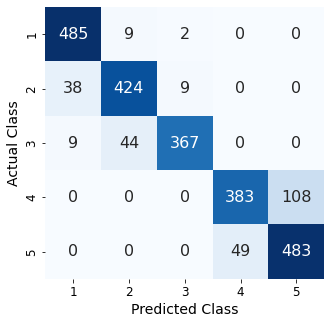

In [27]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_mtx(cm, figsize=(5, 5))
plt.show()